In [12]:
pip install pandas sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [435]:
import pandas as pd
import sqlite3

In [714]:
data_2000season = pd.read_csv("./play_by_play_2000.csv").drop("desc",axis=1)
data_2025season = pd.read_csv("./play_by_play_2025.csv").drop("desc",axis=1)

/var/folders/61/29tst9jn6d7frs7xmxcnb_480000gn/T/ipykernel_92095/773873724.py:1: DtypeWarning: Columns (37,45,179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,248,249,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2000season = pd.read_csv("./play_by_play_2000.csv").drop("desc",axis=1)
/var/folders/61/29tst9jn6d7frs7xmxcnb_480000gn/T/ipykernel_92095/773873724.py:2: DtypeWarning: Columns (45,179,180,182,183,189,190,203,204,205,206,218,219,220,222,224,226,233,234,235,236,237,238,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2025season = pd.read_csv("./play_by_play_2025.csv").drop("desc",axis=1)


# NFL 4th Down Tendencies

### It is no secret that in the last few years the amount of instances where NFL teams "go for it" on 4th down has seemingly risen dramatically (thank you, Dan Campbell). This high risk, high reward style of play generally leads to more exciting games and can help the offensive team secure otherwise unlikely wins. How much more common have these risky decisions really become though? Has there actually been a dramatic increase in fourth down attempts, or has the increased scrutiny of each in-game decision from media outlets only given the illusion of an increase in risky play? Also, if risky play has indeed increased, what are the conditions under which these risks have become more common? Do they contribute to winning?

### In the following queries, we take a look at these questions using two datasets containing play-by-play information from the 2000 and 2025 seasons, respectively. This will allow comparisons between current gameplay trends and those from 25 years ago (which one would think would be more conservative).

# NFL 2000 Season 4th Down Data

### The following query will allow us to only take a subset of the 2000 season data relevant to 4th down attempts and results. We will also look at whether or not the offensive team successfully achieved the first down and the impact this had on the final game result. The resulting dataset is still too large to practically investigate as raw data, so I will create a few plots using panda for efficient visualization. In order to more easily sort the data for visualization, the following shorthand notation will be adopted: +1 indicates a positive result (e.g., achieved a first down), 0 indicates a neutral result (e.g., a tied score), -1 indicates a negative result (e.g., did not get the first down). 

In [718]:
conn2000 = sqlite3.connect('data_2000season.db')
data_2000season.to_sql('nfl2000season_data_table', conn2000, if_exists='replace', index=False)

query2000 = """-- 2000 NFL Season 4th Down Data
select play_type,
case
	when play_type like "%field_goal%" then -1
    when play_type like "%punt%" then -1
    when play_type like "%qb_kneel%" then -1
    when play_type like "%run%" then 1
    when play_type like "%pass%" then 1
end as Attempt,
case
	when result > 0 then 1
    when result < 0 then -1
    when result = 0 then -1
end as Win_Lose,
case
	when score_differential < 0 then -1
    when score_differential > 0 then 1
    when score_differential = 0 then 0
end as Current_Score,
case
	when game_seconds_remaining > (3600 / 4) then -1
    when game_seconds_remaining <= (3600 / 4) then 1
end as In_Fourth_Quarter,
case
	when yardline_100 <= 20 then 1
    when yardline_100 > 20 then -1
end as In_Redzone,
case
	when yards_gained >= ydstogo then 1
    when yards_gained < ydstogo then -1
end as Play_Result
from nfl2000season_data_table
where down = "4.0"
and play_type != "no_play"
and play_type != ""
limit 5000"""

df_2000 = pd.read_sql_query(query2000, conn2000)

conn2000.close()

# NFL 2025 Season 4th Down Data

### Here we repeat the previous query using the data from the 2025 NFL season.

In [720]:
conn2025 = sqlite3.connect('data_2025season.db')
data_2025season.to_sql('nfl2025season_data_table', conn2025, if_exists='replace', index=False)

query2025 = """-- 2025 NFL Season 4th Down Data
select play_type,
case
	when play_type like "%field_goal%" then -1
    when play_type like "%punt%" then -1
    when play_type like "%qb_kneel%" then -1
    when play_type like "%run%" then 1
    when play_type like "%pass%" then 1
end as Attempt,
case
	when result > 0 then 1
    when result < 0 then -1
    when result = 0 then -1
end as Win_Lose,
case
	when score_differential < 0 then -1
    when score_differential > 0 then 1
    when score_differential = 0 then 0
end as Current_Score,
case
	when game_seconds_remaining > (3600 / 4) then -1
    when game_seconds_remaining <= (3600 / 4) then 1
end as In_Fourth_Quarter,
case
	when yardline_100 <= 20 then 1
    when yardline_100 > 20 then -1
end as In_Redzone,
case
	when yards_gained >= ydstogo then 1
    when yards_gained < ydstogo then -1
end as Play_Result
from nfl2025season_data_table
where down = "4.0"
and play_type != "no_play"
and play_type != ""
limit 5000"""

df_2025 = pd.read_sql_query(query2025, conn2025)

conn2025.close()

# Pandas Visualization

### Now that we successfully extracted our data and created a pandas dataframe, we can visualize it. I am including a simple Python function simplify the analysis.

In [722]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

#Function that reads in desired columns and sorts into different types of outcomes
def match(column_list, dataframe):

    #List used to store outcomes for category of interest
    value_list = []
    
    for index, row in dataframe.iterrows():
        value_list.append(f"{[row[f"{column_list[i]}"] for i in range(len(column_list))]}")

    return dict(Counter(value_list))            


# Total 4th Down Attempts

### First, we compare the total 4th down attempts between the two seasons. An increasingly aggressive style of play is confirmed in the modern era data, with nearly double the fourth down attempts in 2025 compared to the 2000 season.

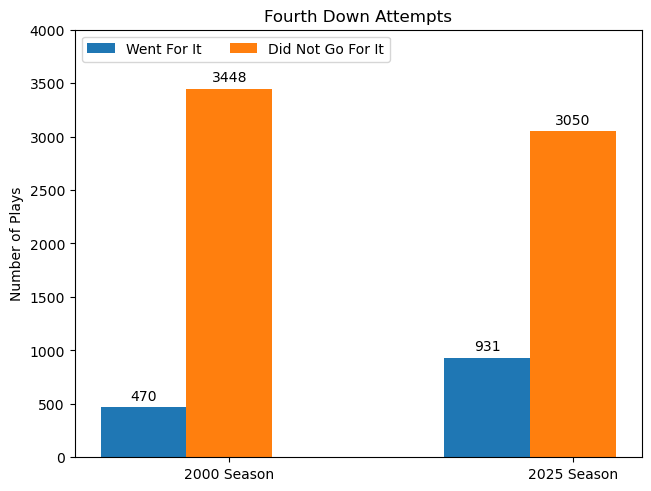

In [725]:
outcomes2000 = match(["Attempt"], df_2000)
outcomes2025 = match(["Attempt"], df_2025)

seasons = ("2000 Season", "2025 Season")
categories = {
    "Went For It": (outcomes2000.get("[1]"), outcomes2025.get("[1]")),
    "Did Not Go For It": (outcomes2000.get("[-1]"), outcomes2025.get("[-1]"))
}

x = np.arange(len(seasons))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for labels, values in categories.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=labels)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Number of Plays")
ax.set_title("Fourth Down Attempts")
ax.set_xticks(x + width, seasons)
ax.legend(loc="upper left", ncols=2)
ax.set_ylim(0, 4000)

plt.show()

# 4th Down Attempts in the 4th Quarter

### Next, we look at the ratio of 4th down attempts in the 4th quarter vs other times in the game.

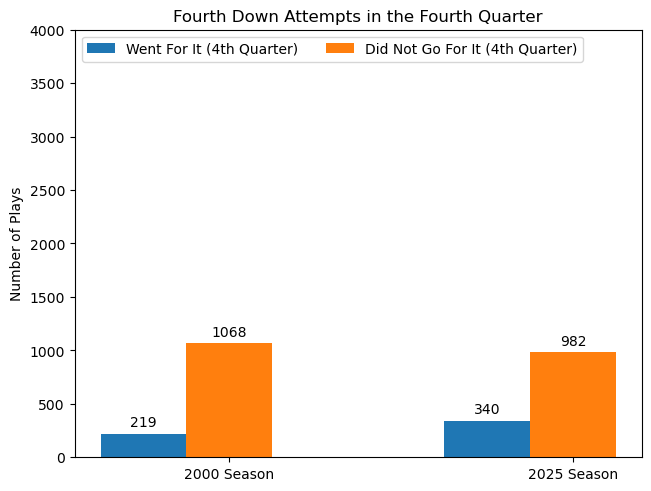

In [727]:
outcomes2000 = match(["Attempt", "In_Fourth_Quarter", "Current_Score"], df_2000)
outcomes2025 = match(["Attempt", "In_Fourth_Quarter", "Current_Score"], df_2025)

seasons = ("2000 Season", "2025 Season")
categories = {
    "Went For It (4th Quarter)": (outcomes2000.get("[1, 1, -1]"), outcomes2025.get("[1, 1, -1]")),
    "Did Not Go For It (4th Quarter)": (outcomes2000.get("[-1, -1, -1]"), outcomes2025.get("[-1, -1, -1]"))
}

x = np.arange(len(seasons))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout="constrained")

for labels, values in categories.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=labels)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Number of Plays")
ax.set_title("Fourth Down Attempts in the Fourth Quarter")
ax.set_xticks(x + width, seasons)
ax.legend(loc="upper left", ncols=2)
ax.set_ylim(0, 4000)

plt.show()

# 4th Down Attempts Leading to Wins

### Next, we look at how many of these fourth quarter times 4th down attempts resulted in wins. While the attempts are higher in 2025, this does not correspond to a higher win-rate. Only 63% of 2025 attempts resulted in a win, while 69% of the 2000 attempts resulted in a win.

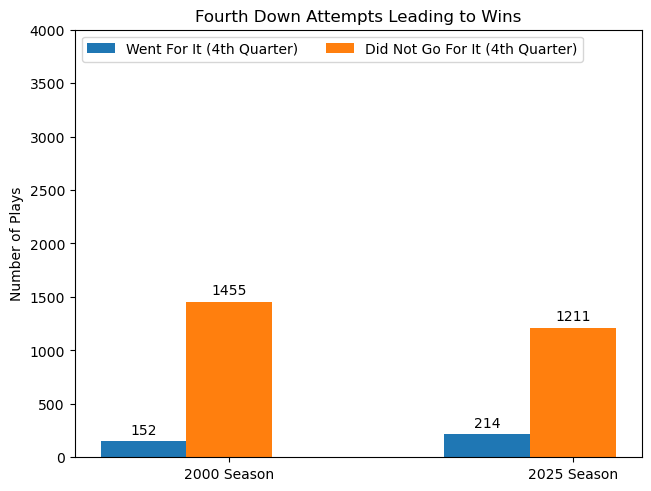

In [731]:
outcomes2000 = match(["Attempt", "In_Fourth_Quarter", "Win_Lose"], df_2000)
outcomes2025 = match(["Attempt", "In_Fourth_Quarter", "Win_Lose"], df_2025)

seasons = ("2000 Season", "2025 Season")
categories = {
    "Went For It (4th Quarter)": (outcomes2000.get("[1, 1, 1]"), outcomes2025.get("[1, 1, 1]")),
    "Did Not Go For It (4th Quarter)": (outcomes2000.get("[-1, -1, 1]"), outcomes2025.get("[-1, -1, 1]"))
}

x = np.arange(len(seasons))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout="constrained")

for labels, values in categories.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=labels)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Number of Plays")
ax.set_title("Fourth Down Attempts Leading to Wins")
ax.set_xticks(x + width, seasons)
ax.legend(loc="upper left", ncols=2)
ax.set_ylim(0, 4000)

plt.show()

# Successful 4th Down Attempts

### Lastly, we look to see if going for it on 4th down in 2025 is more successful on average than the 2000 season. This is probably the most interesting result, with the success rate reaching over 50% (approximately 55%) for the 2025 season, which is around an 8% incerease in success from the 2000 season (47%). It would be interesting to see which factors contribute to this result (for example, the recent effectiveness of the "tush push" style plays) and this will be the topic of future analysis.

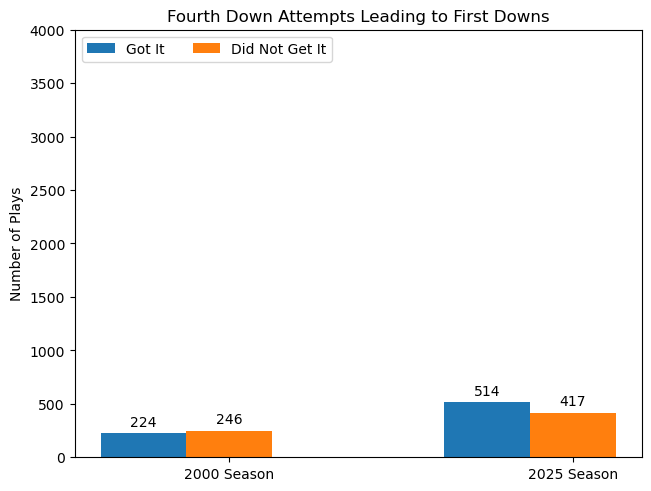

In [736]:
outcomes2000 = match(["Attempt", "Play_Result"], df_2000)
outcomes2025 = match(["Attempt", "Play_Result"], df_2025)

seasons = ("2000 Season", "2025 Season")
categories = {
    "Got It": (outcomes2000.get("[1, 1]"), outcomes2025.get("[1, 1]")),
    "Did Not Get It": (outcomes2000.get("[1, -1]"), outcomes2025.get("[1, -1]"))
}

x = np.arange(len(seasons))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout="constrained")

for labels, values in categories.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=labels)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Number of Plays")
ax.set_title("Fourth Down Attempts Leading to First Downs")
ax.set_xticks(x + width, seasons)
ax.legend(loc="upper left", ncols=2)
ax.set_ylim(0, 4000)

plt.show()